# Mini-project 1: Deep Q-learning for Epidemic Mitigation

## Imports

In [2]:
"""Environment imports"""
from epidemic_env.agent import Agent
from epidemic_env.dynamics import ModelDynamics
from epidemic_env.env import Env

"""Pytorch and numpy imports"""
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np

#@formatter:off
%matplotlib inline
#@formatter:on

In [3]:


def plot_results(total, actions, cities):
    fig = plt.figure(figsize=(14, 10))
    ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
    ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
    ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
    ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
    ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1, 9)]
    ax_right = {k: ax_right[_id] for _id, k in enumerate(cities.keys())}

    [ax_leftstate.plot(y) for y in total.values()]
    ax_leftstate.legend(total.keys())
    ax_leftstate.set_title('Full state')
    ax_leftstate.set_ylabel('number of people in each state')

    [ax_leftobs.plot(total[y]) for y in ['infected', 'dead']]
    ax_leftobs.legend(['infected', 'dead'])
    ax_leftobs.set_title('Observable state')
    ax_leftobs.set_ylabel('number of people in each state')

    ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8), aspect='auto')
    ax_leftactions.set_title('Actions')
    ax_leftactions.set_yticks([0, 1, 2, 3])
    ax_leftactions.set_yticklabels(list(actions.keys()))
    ax_leftactions.set_xlabel('time (in weeks)')

    [ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
    [ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
    [ax.set_ylabel(c) for c, ax in ax_right.items()]
    [ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
    # ax_right['Zürich'].set_xlabel('time (in weeks)')
    # ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

    fig.tight_layout()
    plt.show()

In [4]:
def parse_infos(infos_list):
    """ Parse the logs """
    total = {p: np.array([getattr(l.total, p) for l in infos_list]) for p in dyn.parameters}
    cities = {c: {p: np.array([getattr(l.city[c], p) for l in infos_list]) for p in dyn.parameters} for c in dyn.cities}
    actions = {a: np.array([l.action[a] for l in infos_list]) for a in infos_list[0].action.keys()}

    return total, actions, cities

## Question 1

In [5]:
dyn = ModelDynamics('config/switzerland.yaml')
env = Env(dyn,  # We pass the dynamical model to the environment
          action_space=None,  # Here one could pass an openai gym action space that can then be sampled
          observation_space=None,  # Here one could pass an openai gym obs space that can then be sampled
          )
obs, info = env.reset(seed=0)
action = {  # DO NOTHING
    'confinement': False,
    'isolation': False,
    'hospital': False,
    'vaccinate': False,
}

In [6]:
""" Run basic simulation (no actions) """
infos_list = []
for i in range(30):
    obs, reward, done, info = env.step(action)
    infos_list.append(info)

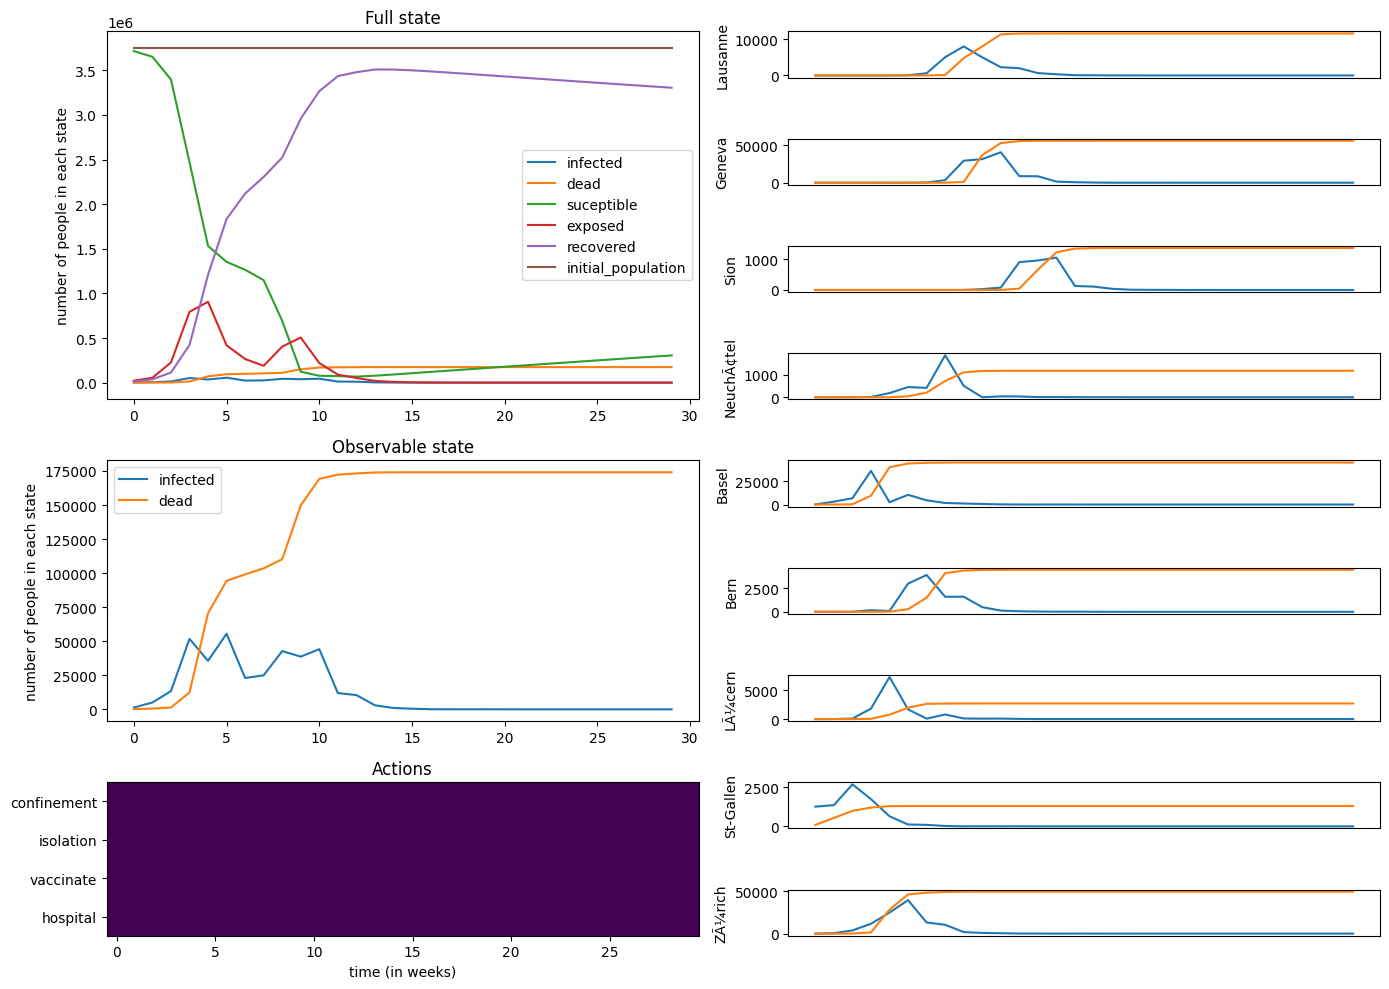

In [7]:
plot_results(*parse_infos(infos_list))

### Question 1.a).1

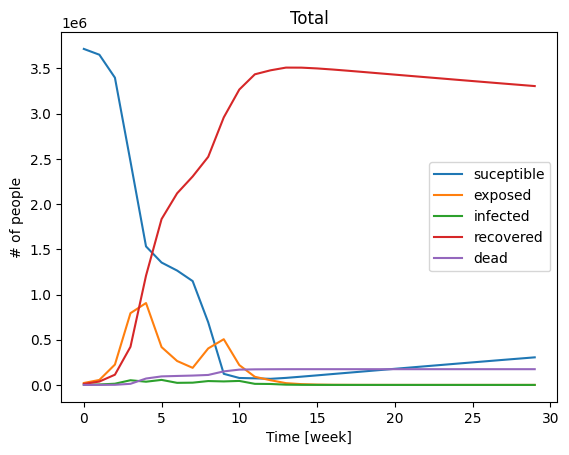

In [8]:
totals = [info.total for info in infos_list]
suceptibles = [total.suceptible for total in totals]
exposeds = [total.exposed for total in totals]
infected = [total.infected for total in totals]
recovereds = [total.recovered for total in totals]
deads = [total.dead for total in totals]

plt.plot(suceptibles, label='suceptible')
plt.plot(exposeds, label='exposed')
plt.plot(infected, label='infected')
plt.plot(recovereds, label='recovered')
plt.plot(deads, label='dead')
plt.xlabel('Time [week]')
plt.ylabel('# of people')
plt.title('Total')
plt.legend()
plt.show()

### Question 1.a).2

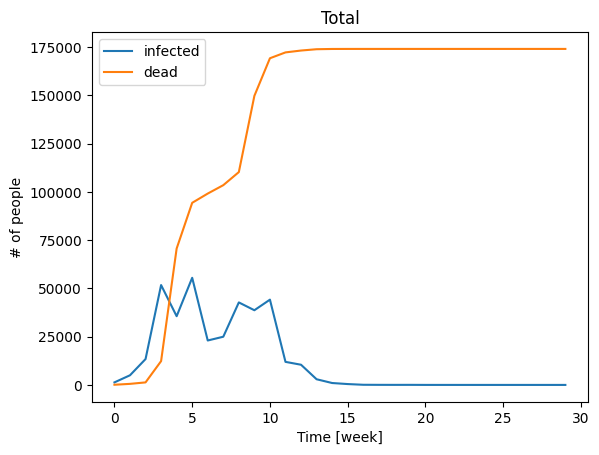

In [9]:
plt.plot(infected, label='infected')
plt.plot(deads, label='dead')
plt.xlabel('Time [week]')
plt.ylabel('# of people')
plt.title('Total')
plt.legend()
plt.show()

### Question 1.a).3

In [10]:
cities = [info.city for info in infos_list]

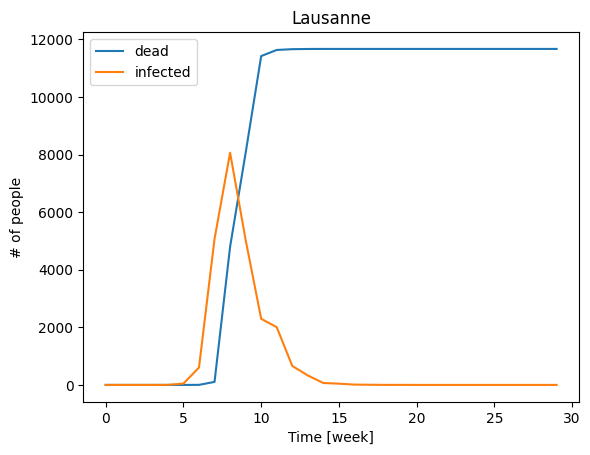

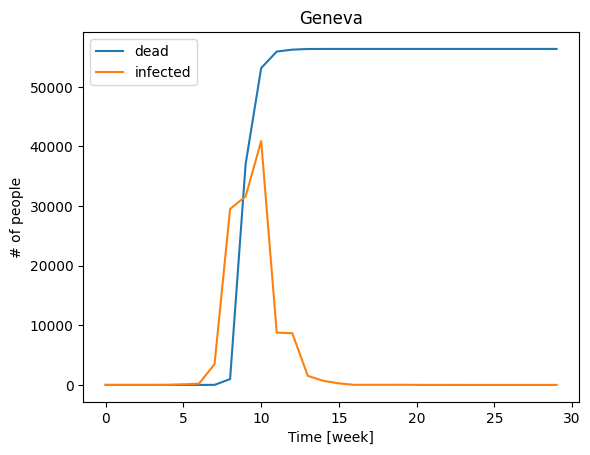

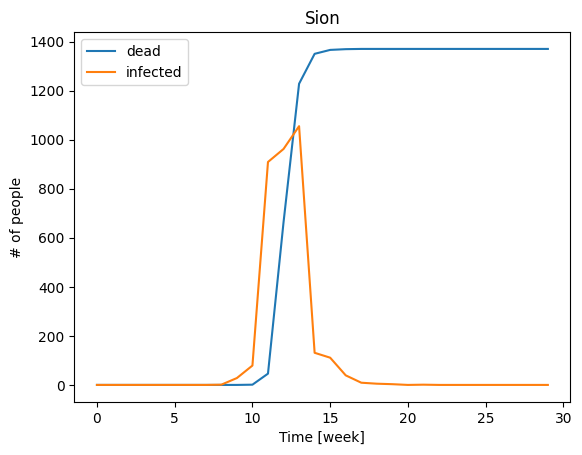

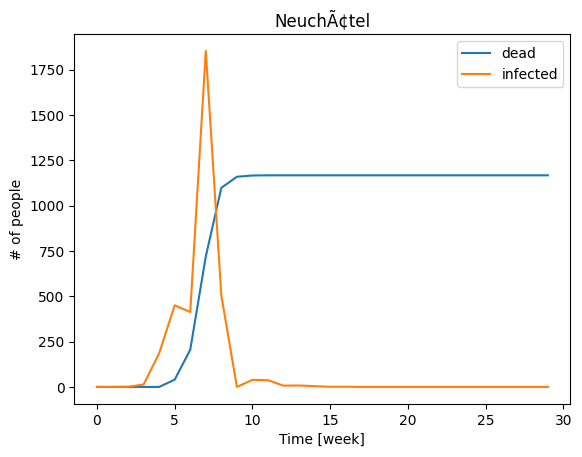

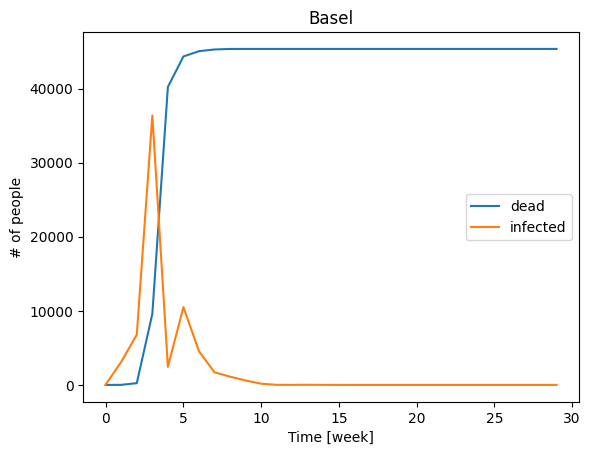

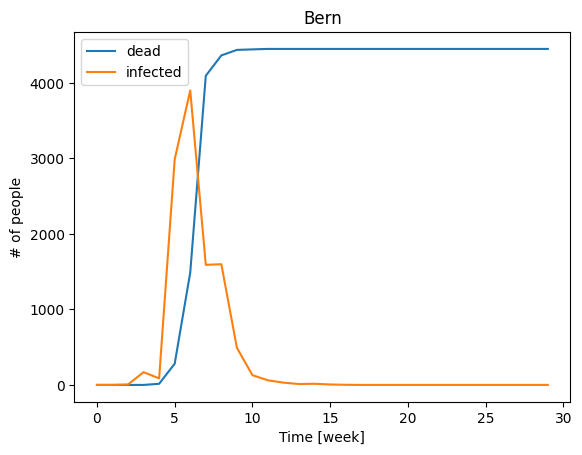

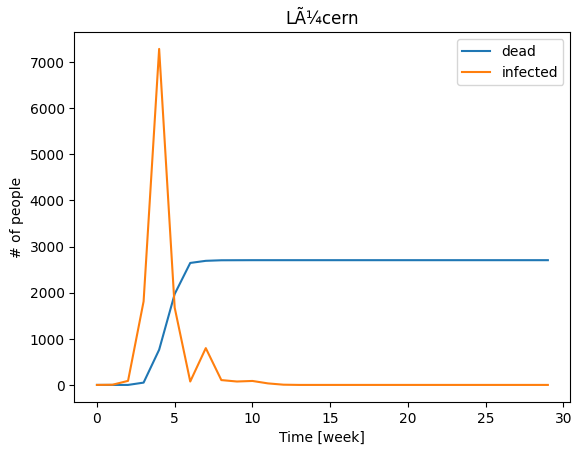

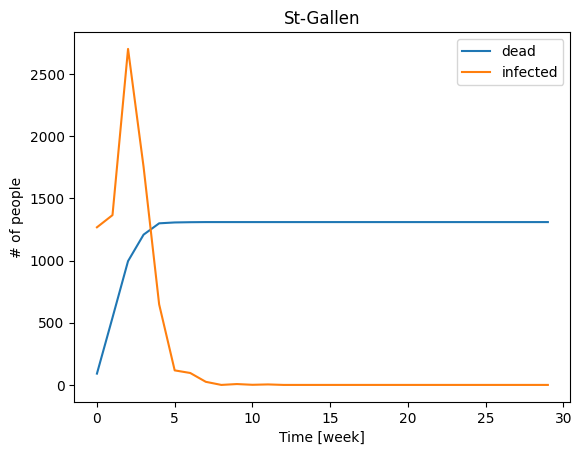

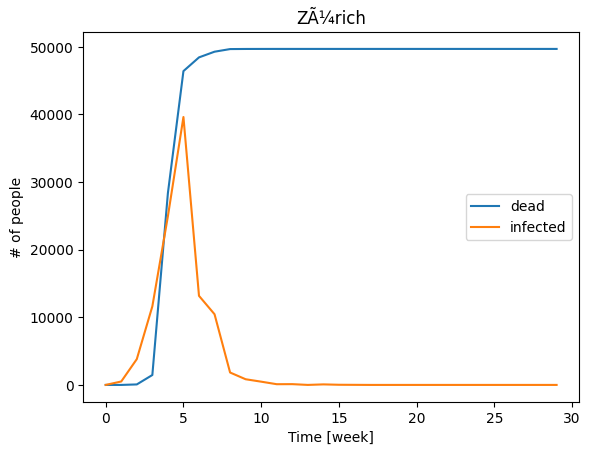

In [11]:
cities = [info.city for info in infos_list]
# take the first one to have the names
city_names = list(cities[0])

for name in city_names:
    params = [city[name] for city in cities]
    deads = [param.dead for param in params]
    infected = [param.infected for param in params]
    plt.plot(deads, label=f'dead')
    plt.plot(infected, label=f'infected')
    plt.xlabel('Time [week]')
    plt.ylabel('# of people')
    plt.title(name)
    plt.legend()
    plt.show()

### Discuss the evolution of the variables over time.
TODO

## Question 2 a)

In [12]:
class RussoPolicy(Agent):
    def __init__(self):
        self.total_infected = 0
        self.confined = False
        self.wi = 0
        self.confinment_remaining = 0

    def load_model(self, savepath: str):
        pass

    def optimize_model(self) -> float:
        pass

    def save_model(self, savepath: str):
        pass

    def reset(self):
        self.total_infected = 0
        self.confined = False
        self.wi = 0
        self.confinment_remaining = 0

    def act(self, obs, reward):
        self.total_infected += sum(obs.total.infected)
        self.wi += 1

        confinment = False

        if self.confinment_remaining > 1:
            self.confinment_remaining -= 1
            confinment = True

        elif self.confinment_remaining == 1:
            self.confinment_remaining -= 1
            confinment = False

        elif self.total_infected > 20000:
            self.confinment_remaining = 4
            confinment = True

        return {
            'confinement': confinment,
            'isolation': False,
            'hospital': False,
            'vaccinate': False,
        }

In [13]:
dyn = ModelDynamics('config/switzerland.yaml')
env = Env(dyn,  # We pass the dynamical model to the environment
          action_space=None,  # Here one could pass an openai gym action space that can then be sampled
          observation_space=None,  # Here one could pass an openai gym obs space that can then be sampled
          )
obs, info = env.reset(seed=0)
action = None
infos_list = []
policy = RussoPolicy()
actions = []
reward = [[0]]
for i in range(30):
    action = policy.act(obs, reward[0][0])
    actions.append(action['confinement'])
    obs, reward, done, info = env.step(action)
    infos_list.append(info)

In [ ]:
total_russo, actions_russo, cities_russo = parse_infos(infos_list)
plot_results(total_russo, actions_russo, cities_russo)

### 1

In [ ]:
totals = [info.total for info in infos_list]
suceptibles = [total.suceptible for total in totals]
exposeds = [total.exposed for total in totals]
infected = [total.infected for total in totals]
recovereds = [total.recovered for total in totals]
deads = [total.dead for total in totals]

plt.plot(suceptibles, label='suceptible')
plt.plot(exposeds, label='exposed')
plt.plot(infected, label='infected')
plt.plot(recovereds, label='recovered')
plt.plot(deads, label='dead')
plt.xlabel('Time [week]')
plt.ylabel('# of people')
plt.title('Total')
plt.legend()
plt.show()

### 2

In [ ]:
plt.plot(infected, label='infected')
plt.plot(deads, label='dead')
plt.xlabel('Time [week]')
plt.ylabel('# of people')
plt.title('Total')
plt.legend()
plt.show()

### 3

In [ ]:
fig = plt.figure(figsize=(14, 10))

russo_cities_plot = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
russo_cities_plot += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1, 9)]
russo_cities_plot = {k: russo_cities_plot[_id] for _id, k in enumerate(cities_russo.keys())}

[ax.plot(cities_russo[c]['infected']) for c, ax in russo_cities_plot.items()]
[ax.plot(cities_russo[c]['dead']) for c, ax in russo_cities_plot.items()]
[ax.set_ylabel(c) for c, ax in russo_cities_plot.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in russo_cities_plot.items()]

fig.legend(['infected', 'dead'])

plt.show()

### 4

In [ ]:
ax_actions = plt.subplot2grid(shape=(18, 1), loc=(0, 0), colspan=1, rowspan=9)
ax_actions.imshow(np.array([v for v in actions_russo.values()]).astype(np.uint8), aspect='auto')
ax_actions.set_title('Actions')
ax_actions.set_yticks([0, 1, 2, 3])
ax_actions.set_yticklabels(list(actions_russo.keys()))
ax_actions.set_xlabel('time (in weeks)')
plt.show()

## Question 2 b)

In [ ]:
def run_episode(policy: Agent, env: Env, weeks: int = 30, seed: int = 0) -> (list, list, ...):
    # We pass a seed to the env to ensure reproductibility
    obs, info = env.reset(seed=seed)
    policy.reset()
    cumulative_reward = 0
    action_list, obs_list, reward_list = [], [], []
    reward = torch.tensor([[0]])
    for i in range(weeks):
        action = policy.act(obs, reward)
        obs, reward, done, info = env.step(action)
        cumulative_reward = reward + cumulative_reward
        action_list.append(action)
        obs_list.append(obs)
        reward_list.append(reward)
    return action_list, obs_list, cumulative_reward

In [ ]:
def evaluate_policy(policy: Agent, env: Env, iterations: int = 50) -> (list, list, list):
    number_of_confined_days_list = []
    cumulative_reward_list = []
    number_of_total_deaths_list = []
    for i in range(iterations):
        # action_list, observation_list
        action_list, obs_list, cumulative_reward = run_episode(policy, env, weeks=30, seed=i)
        number_of_confined_days = np.sum([7 if action['confinement'] else 0 for action in action_list])
        number_of_deaths = np.sum([np.sum(obs.total.dead) for obs in obs_list])
        cumulative_reward_list.append(cumulative_reward)
        number_of_confined_days_list.append(number_of_confined_days)
        number_of_total_deaths_list.append(number_of_deaths)
    cumulative_reward_list = [tensor[0, 0] for tensor in cumulative_reward_list]
    return number_of_confined_days_list, cumulative_reward_list, number_of_total_deaths_list

In [ ]:
number_of_confined_days_list, cumulative_reward_list, number_of_total_deaths_list = evaluate_policy(RussoPolicy(), env)

In [ ]:
number_of_confined_days_array = np.array(number_of_confined_days_list, dtype=float).reshape((-1, 1))
cumulative_reward_array = np.array(cumulative_reward_list, dtype=float).reshape((-1, 1))
number_of_total_deaths_array = np.array(number_of_total_deaths_list, dtype=float).reshape((-1, 1))

In [ ]:
""" Plot results """
fig, ax = plt.subplots(3, 1, figsize=(18, 8))


def hist_avg(ax, data, title):
    ymax = 50
    if title == 'deaths':
        x_range = (1000, 200000)
    elif title == 'cumulative rewards':
        x_range = (-300, 300)
    elif 'days' in title:
        x_range = (0, 200)
    else:
        raise ValueError(f'{title} is not a valid title')
    ax.set_title(title)
    ax.set_ylim(0, ymax)
    ax.vlines([np.mean(data)], 0, ymax, color='red')
    ax.hist(data, bins=60, range=x_range)


hist_avg(ax[0], number_of_total_deaths_array, 'deaths')
hist_avg(ax[1], cumulative_reward_array, 'cumulative rewards')
hist_avg(ax[2], number_of_confined_days_array, 'confined days')
fig.tight_layout()
plt.show()

## Question 3

In [ ]:
# For each deep-learning policy that you train in this project we recommend that you use the following
# hyperparameters. If you wish so, you are free to test other values, but as searching through the hyperparameterspace can be quite a tedious experience we are giving you values that we know will allow the algorithm to converge
# to a good policy
def create_model(input_dim: int, output_dim: int, activation: nn.Module = nn.ReLU()):
    return nn.Sequential(
        nn.Linear(input_dim, 64),
        activation,
        nn.Linear(64, 32),
        activation,
        nn.Linear(32, 16),
        activation,
        nn.Linear(16, output_dim)
    )

In [ ]:
# Note unless special measures are taken, the training of neural networks is non-deterministic in most deeplearning libraries. To ensure that your results are reproducible you will thus need to seed not only the environment but also your deep-learning library. Refer to the jupyter tutorial notebook for instructions.
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

In [ ]:
from epidemic_env.dynamics import Observation


def observation2tensor(obs: Observation):
    """
    Convert an Observation object to a torch tensor so it can be used to feed a nn
    """
    # 9 cities, 2 for dead/infected, 7=|city.dead| days per week
    # -> 2*7*9 sized vector
    total_population = sum(obs.pop.values())
    obs = torch.tensor([x for city in obs.city.values() for x in city.dead + city.infected]).float()

    # scale the observation and apply ^1/4 to avoid tiny values
    obs = (obs / total_population) ** .25
    return obs


observation2tensor(obs)

### Question 3.a)

In [ ]:
epsilon = .7

In [ ]:

class AgentDQN(Agent):
    """
    Implemented by following this tutorial : https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
    """

    def __init__(self, *args, **kwargs):
        options = kwargs.get('options', {})

        # set the seed for reproducibility
        torch.manual_seed(options['seed'] if 'seed' in options else 0)
        torch.use_deterministic_algorithms(True)

        self.update_episode = options['update_episode'] if 'update_episode' in options else 5
        self.learning_rate = options['learning_rate'] if 'learning_rate' in options else 5e-3
        self.discount_factor = options['discount_factor'] if 'discount_factor' in options else .9
        self.buffer_size = options['buffer_size'] if 'buffer_size' in options else 2e4
        self.batch_size = options['batch_size'] if 'batch_size' in options else 2048
        self.epsilon = options['epsilon'] if 'epsilon' in options else .7

        self.episode = 0
        self.buffer = []  # contains (states, actions, next_state, reward) tuples
        self.last_obs, self.last_action = None, None

        in_dim, out_dim = 2 * 9 * 7, 2
        self.Q_network = create_model(in_dim, out_dim, nn.ReLU())
        self.Q_target_network = create_model(in_dim, out_dim, nn.ReLU())
        self.optimizer = torch.optim.AdamW(self.Q_network.parameters(), lr=self.learning_rate, amsgrad=True)

        self.best_eval_reward = -float('inf')  # for model saving

    def load_model(self, savepath: str):
        self.Q_network.load_state_dict(torch.load(savepath))
        # load the target network with the same weights
        self.Q_target_network.load_state_dict(self.Q_network.state_dict())

    def optimize_model(self) -> float:
        if len(self.buffer) < self.batch_size:
            return 0
        transitions = torch.randperm(len(self.buffer))[:self.batch_size]
        transitions = [self.buffer[i] for i in transitions]
        state_batch, action_batch, next_state_batch, reward_batch = zip(*transitions)
        state_batch, next_state_batch, reward_batch = map(torch.stack, (state_batch, next_state_batch, reward_batch))
        reward_batch = reward_batch.reshape((-1, 1))  # reshape to (batch_size, 1)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the columns of actions taken.
        state_action_values = self.Q_network(state_batch)

        # Compute V(s_{t+1}) for all next states.
        with torch.no_grad():
            next_state_values = self.Q_target_network(next_state_batch)

        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.discount_factor) + reward_batch

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # update the target network every update_episode steps
        if self.episode % self.update_episode == 0:
            self.Q_target_network.load_state_dict(self.Q_network.state_dict())

        # do not do in place gradient clipping
        return loss.item()

    def save_model(self, savepath: str):
        torch.save(self.Q_network.state_dict(), savepath)

    def reset(self):
        """
        Called at the beginning of each episode
        """
        self.last_obs = None
        self.last_action = None
        self.episode += 1

    def act(self, obs, reward):
        # cast the observation
        obs = observation2tensor(obs)
        # get the next action
        # epsilon-greedy policy
        if torch.rand(1) < self.epsilon:
            action = torch.rand(2)
        else:
            with torch.no_grad():
                action = self.Q_network(obs)

        if self.last_obs is not None and self.last_action is not None:
            # store the transition
            action = torch.eye(2)[torch.argmax(action)]
            self.buffer.append((self.last_obs, self.last_action, obs, reward))

        self.last_action = action
        self.last_obs = obs
        if len(self.buffer) > self.buffer_size:
            self.buffer.pop(0)
        # return next action
        return {
            'confinement': bool(np.argmax(action.numpy())),
            'isolation': False,
            'hospital': False,
            'vaccinate': False,
        }

In [ ]:
def train(policy: Agent, env: Env, iterations: int):
    eval_trace, training_trace, loss_trace = [], [], []

    for i in range(iterations):
        # Run an episode.
        action_list, obs_list, cumulated_reward = run_episode(policy, env, weeks=30, seed=i)

        # Log the cumuative reward to training trace
        training_trace.append(cumulated_reward.item())

        # run a training step :
        loss_trace.append(policy.optimize_model())

        if (i + 1) % 50 == 0:
            _, cumulated_reward_list, _ = evaluate_policy(policy, env, 20)

            # Compute the average cumulative reward over the 20 evaluation episodes and log it to eval trace.
            average_cumulated_reward = sum(cumulated_reward) / len(cumulated_reward_list)
            eval_trace.append(average_cumulated_reward.item())

            # saving the model if it performs better
            if average_cumulated_reward > policy.best_eval_reward:
                policy.save_model('models/best_model_1.pth')
                policy.best_eval_reward = average_cumulated_reward

            # print the average cumulative reward
            print(f'Checkpoint {i // 50 + 1} : average cumulated reward = {average_cumulated_reward}')

    return eval_trace, training_trace, loss_trace

In [ ]:
options = {
    "seed": 0,
    "update_episodes": 5,  # target update rate : (fully) update the target network every 5 episodes
    "learning_rate": 5e-3,  # learning rate : 5 · 10−3 (when the action-space is binary)
    "discount_factor": .9,
    "buffer_size": 2e4,
    "batch_size": 2048,
    "epsilon": .7,
}

agentDQN1 = AgentDQN(options)
iterations = 500
eval_trace, training_trace, loss_trace = train(agentDQN1, env, iterations=iterations)

In [ ]:
plt.scatter(range(iterations), training_trace, label='training trace')
plt.plot(range(50, iterations + 1, 50), eval_trace, label='eval trace', color='red')
plt.xlabel('episode')
plt.ylabel('cumulative reward')
plt.legend()
plt.show()

plt.plot(loss_trace)
plt.xlabel('episode')
plt.ylabel('loss')
plt.show()

### Question 3.b)

In [ ]:
def train_decreasing_exploration(policy: Agent, env: Env, iterations: int, eps_0: float, eps_min: float):
    """
    redefine the train function to update epsilon at each iteration
    """
    eval_trace, training_trace, loss_trace = [], [], []

    for i in range(iterations):
        # update epsilon
        policy.epsilon = max(eps_0 * (iterations - i) / iterations, eps_min)

        # Run an episode.
        action_list, obs_list, cumulated_reward = run_episode(policy, env)

        # Log the cumuative reward to training trace
        training_trace.append(cumulated_reward.item())

        # run a training step :
        loss_trace.append(policy.optimize_model())

        if (i + 1) % 50 == 0:
            _, cumulated_reward_list, _ = evaluate_policy(policy, env, 20)

            # Compute the average cumulative reward over the 20 evaluation episodes and log it to eval trace.
            average_cumulated_reward = (sum(cumulated_reward) / len(cumulated_reward_list)).item()
            eval_trace.append(average_cumulated_reward)

            # print the average cumulative reward
            print(f'Checkpoint {i // 50 + 1} : average cumulated reward = {average_cumulated_reward}')

            # saving the model if it performs better
            if average_cumulated_reward > policy.best_eval_reward:
                policy.save_model('models/best_model_2.pth')
                policy.best_eval_reward = average_cumulated_reward

    return eval_trace, training_trace, loss_trace

In [ ]:
agentDQN2 = AgentDQN()
eval_trace2, training_trace2, loss_trace2 = train_decreasing_exploration(agentDQN2, env, iterations=500, eps_0=.7,
                                                                         eps_min=.2)

In [ ]:
plt.scatter(range(iterations), training_trace2, label='training trace')
plt.plot(range(50, iterations + 1, 50), eval_trace2, label='eval trace', color='red')
plt.xlabel('episode')
plt.ylabel('cumulative reward')
plt.legend()
plt.show()

plt.plot(loss_trace2)
plt.xlabel('episode')
plt.ylabel('loss')
plt.show()

### Question 3.c)

In [ ]:
for model_path in ['models/best_model_1.pth', 'models/best_model_2.pth']:
    agentDQN = AgentDQN()
    agentDQN.load_model(model_path)

    number_of_confined_days_list, cumulative_reward_list, number_of_total_deaths_list = evaluate_policy(agentDQN, env)
    number_of_confined_days_array = np.array(number_of_confined_days_list, dtype=float).reshape((-1, 1))
    cumulative_reward_array = np.array(cumulative_reward_list, dtype=float).reshape((-1, 1))
    number_of_total_deaths_array = np.array(number_of_total_deaths_list, dtype=float).reshape((-1, 1))
    fig, ax = plt.subplots(3, 1)
    hist_avg(ax[0], number_of_total_deaths_array, 'deaths')
    hist_avg(ax[1], number_of_confined_days_array, 'confinment days')
    hist_avg(ax[2], cumulative_reward_array, 'cumulative rewards')
    fig.tight_layout()
    print(f'Agent {model_path} :')
    plt.show()